In [1]:
!pip install timm

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from torch.utils.data import DataLoader, random_split, Dataset
import timm
import seaborn as sns
import os
import tqdm
import matplotlib.pyplot as plt
import random


In [2]:
# Set device (GPU if available, else CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Data Loader

In [7]:
# Define data transformations
train_transform = torchvision.transforms.Compose([
    torchvision.transforms.Resize((224,224)),
    torchvision.transforms.RandomHorizontalFlip(),
    torchvision.transforms.RandomRotation(10),
    torchvision.transforms.ToTensor(),
    torchvision. transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))])

test_transform = torchvision.transforms.Compose([
    torchvision.transforms.Resize((224, 224)),
    torchvision.transforms.ToTensor(),
    torchvision. transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))])



# Define a mapping of class indices to class names
class_mapping = {
    1: 'automobile',
    0: 'airplane',
}
train_classes = [0, 1]


# Download CIFAR-10 training dataset
train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=train_transform)
train_indices = [i for i, target in enumerate(train_dataset.targets) if target in train_classes]

# Create a Subset dataset containing only 'airplane' and 'automobile' samples
train_dataset = torch.utils.data.Subset(train_dataset, train_indices)


# Download CIFAR-10 test dataset
test_dataset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=test_transform)
test_indices = [i for i, target in enumerate(test_dataset.targets) if target in train_classes]
test_dataset = torch.utils.data.Subset(test_dataset, test_indices)



# Define the size of the training and validation sets
train_size = int(0.8 * len(train_dataset))    # 80% for training
valid_size = len(train_dataset) - train_size  # 20% for validation

# Split the dataset
train_dataset, valid_dataset = random_split(train_dataset, [train_size, valid_size])

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = torch.utils.data.DataLoader(valid_dataset, batch_size=16, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=16, shuffle=False)

print("Train Size: ",len(train_loader.dataset))
print("Valid Size: ",len(valid_dataset))
print("Test Size: ",len(test_dataset))







Files already downloaded and verified
Files already downloaded and verified
Train Size:  8000
Valid Size:  2000
Test Size:  2000


# Cross Enropy Loss
In this phase, we exclusively train the ResNet50 model's final classification (fc) layer using Cross-Entropy Loss. We harness the pre-trained feature extraction capabilities of ResNet50 on the CIFAR-10 dataset. The objective is to fine-tune the model's classification abilities for diverse images, isolating training to the fc layer and optimizing performance.

In [5]:
model = timm.create_model('resnet50', pretrained=True)
num_epochs = 10

# change the last layer to 2 classes
model.fc = nn.Linear(2048, 2)
model = model.to(device)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.fc.parameters(), lr=0.001)  # Only train the fc layer

# Training and validation loop
train_losses=[]
train_acc=[]
val_losses=[]
val_acc=[]


for epoch in range(num_epochs):
  # Training phase
  model.train()
  train_loss = 0.0
  val_loss=0.0
  train_correct = 0
  val_correct= 0

  for inputs, labels in tqdm.tqdm(train_loader):

    inputs, labels = inputs.to(device), labels.to(device)

    optimizer.zero_grad()
    outputs = model(inputs)
    loss = criterion(outputs, labels)
    loss.backward()
    optimizer.step()

    train_loss += loss.item()
    pred=outputs.argmax(dim=1,keepdim=True)
    train_correct+=pred.eq(labels.view_as(pred)).sum().item()

  train_losses.append(train_loss/len(train_loader))
  train_acc.append(train_correct / len(train_loader.dataset))

  model.eval()
  with torch.no_grad():
    for inputs, labels in val_loader:
      inputs, labels = inputs.to(device), labels.to(device)
      outputs = model(inputs)
      loss = criterion(outputs, labels)
      val_loss += loss.item()
      pred=outputs.argmax(dim=1,keepdim=True)
      val_correct+=pred.eq(labels.view_as(pred)).sum().item()

  val_losses.append(val_loss / len(val_loader))
  val_acc.append(val_correct / len(val_loader.dataset))

  print(f"Epoch {epoch + 1}/{num_epochs}, Train Loss: {train_losses[-1]:.4f}, Train accuracy:{train_acc[-1]*100:.2f} Validation Loss: {val_losses[-1]:.4f}, Validation accuracy:{val_acc[-1]*100:.2f}")

100%|██████████| 500/500 [01:36<00:00,  5.19it/s]


Epoch 1/10, Train Loss: 0.3479, Train accuracy:87.33 Validation Loss: 0.2325, Validation accuracy:92.10


100%|██████████| 500/500 [01:34<00:00,  5.28it/s]


Epoch 2/10, Train Loss: 0.2360, Train accuracy:91.11 Validation Loss: 0.1852, Validation accuracy:93.95


100%|██████████| 500/500 [01:40<00:00,  4.99it/s]


Epoch 3/10, Train Loss: 0.2198, Train accuracy:91.27 Validation Loss: 0.1755, Validation accuracy:93.55


100%|██████████| 500/500 [01:36<00:00,  5.17it/s]


Epoch 4/10, Train Loss: 0.2062, Train accuracy:92.06 Validation Loss: 0.1504, Validation accuracy:95.25


100%|██████████| 500/500 [01:37<00:00,  5.15it/s]


Epoch 5/10, Train Loss: 0.1862, Train accuracy:92.74 Validation Loss: 0.1437, Validation accuracy:95.10


100%|██████████| 500/500 [01:31<00:00,  5.46it/s]


Epoch 6/10, Train Loss: 0.1845, Train accuracy:92.75 Validation Loss: 0.1610, Validation accuracy:94.40


100%|██████████| 500/500 [01:31<00:00,  5.45it/s]


Epoch 7/10, Train Loss: 0.1814, Train accuracy:92.95 Validation Loss: 0.1385, Validation accuracy:95.75


100%|██████████| 500/500 [01:31<00:00,  5.48it/s]


Epoch 8/10, Train Loss: 0.1680, Train accuracy:93.79 Validation Loss: 0.1328, Validation accuracy:95.40


100%|██████████| 500/500 [01:31<00:00,  5.46it/s]


Epoch 9/10, Train Loss: 0.1835, Train accuracy:92.84 Validation Loss: 0.1358, Validation accuracy:95.80


100%|██████████| 500/500 [01:31<00:00,  5.46it/s]


Epoch 10/10, Train Loss: 0.1703, Train accuracy:93.23 Validation Loss: 0.1346, Validation accuracy:95.60


## Plot Training and Validation Losses and Accuracies

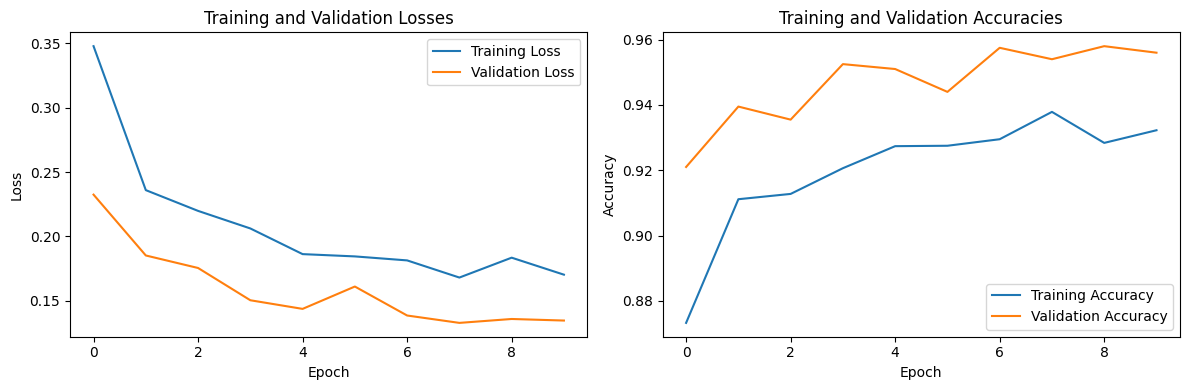

In [6]:
# Plotting losses
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Training and Validation Losses')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Plotting accuracies
plt.subplot(1, 2, 2)
plt.plot(train_acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.title('Training and Validation Accuracies')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()


## Test Accuracy

In [7]:
# Test
test_correct = 0
for inputs,labels in test_loader:
  inputs, labels = inputs.to(device), labels.to(device)
  outputs = model(inputs)
  pred=outputs.argmax(dim=1,keepdim=True)
  test_correct += pred.eq(labels.view_as(pred)).sum().item()

print(f"Test accuracy :{test_correct/len(test_loader.dataset)*100:.2f}")


Test accuracy :96.55


 The accuracy of using this approach is `96.55`which is good

# Triplet Loss

In this segment, our objective is to train a feature extraction model using the triplet loss. To accomplish this, the critical first step involves defining a custom dataset tailored specifically for triplet loss training. This dataset is meticulously crafted to provide anchor, positive, and negative samples essential for the effective learning of feature representations through the triplet loss paradigm.






## Triplet Dataset

In [4]:
class TripletDataset(Dataset):
  def __init__(self, dataset):

    self.dataset = dataset

  def __getitem__(self, index):

    anchor,anchor_class = self.dataset[index]

    positive_index = self._get_positive_index(anchor_class, index)
    negative_index = self._get_negative_index(anchor_class)

    positive,_ = self.dataset[positive_index]
    negative,_ = self.dataset[negative_index]

    return anchor, positive, negative, anchor_class

  def __len__(self):
    return len(self.dataset)

  def _get_positive_index(self, anchor_class, anchor_index):
    while True:
      i_temp=random.randint(0, self.__len__() - 1)
      _,label=self.dataset[i_temp]
      if label==anchor_class and anchor_index !=i_temp:
        return i_temp


  def _get_negative_index(self, anchor_class):
    while True:
      i_temp=random.randint(0, self.__len__() - 1)
      _,label=self.dataset[i_temp]
      if label != anchor_class:
        return i_temp


In [5]:
triplet_train_loader = torch.utils.data.DataLoader(TripletDataset(train_dataset), batch_size=32, shuffle=True)
triplet_val_loader = torch.utils.data.DataLoader(TripletDataset(valid_dataset), batch_size=32, shuffle=True)

Visualize some sample form triplet dataset

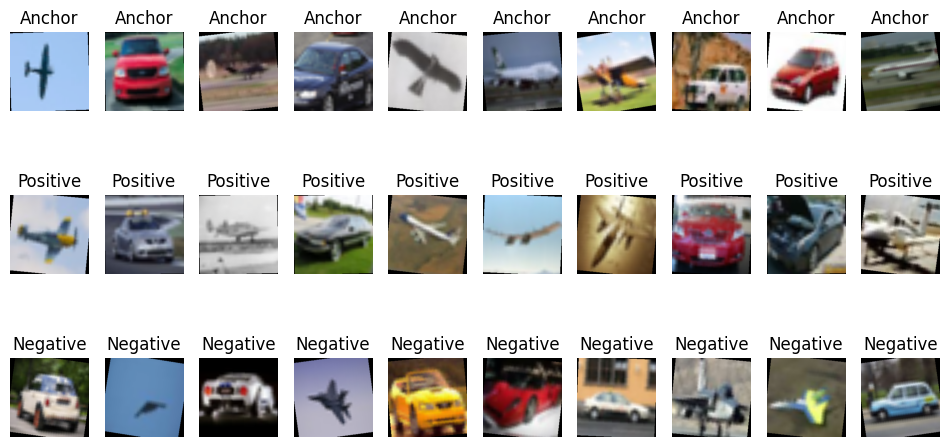

In [10]:
samples_to_display = 10
fig, axes = plt.subplots(3, samples_to_display, figsize=(12, 6))

mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

unnormalize = torchvision.transforms.Normalize(
    mean=[-m/s for m, s in zip(mean, std)],
    std=[1/s for s in std]
)

for anchor, positive, negative,label in triplet_train_loader:

  anchor=unnormalize(anchor)
  positive=unnormalize(positive)
  negative=unnormalize(negative)

  for i in range(samples_to_display):
    axes[0, i].imshow(anchor[i].permute(1, 2, 0))  # Assuming anchor is a tensor
    axes[0, i].set_title(f"Anchor")
    axes[0, i].axis('off')

    # Visualize positive
    axes[1, i].imshow(positive[i].permute(1, 2, 0))  # Assuming positive is a tensor
    axes[1, i].set_title(f"Positive")
    axes[1, i].axis('off')

    # Visualize negative
    axes[2, i].imshow(negative[i].permute(1, 2, 0))  # Assuming negative is a tensor
    axes[2, i].set_title(f"Negative")
    axes[2, i].axis('off')
  break;

plt.show()

## Train feature extractor
Our focus is solely on training the Convolutional Neural Network (CNN) while excluding the fully connected (fc) layer, utilizing the triplet loss.

In [11]:
triplet_model = timm.create_model('resnet50', pretrained=True)
triplet_model.fc = nn.Linear(2048, 2)

# Freeze the fc layers
for param in triplet_model.fc.parameters():
    param.requires_grad = False

triplet_model = triplet_model.to(device)

criterion = nn.TripletMarginLoss()
# Only train the feature extraction layers
optimizer = optim.Adam(filter(lambda p: p.requires_grad, triplet_model.parameters()), lr=0.001)


In [12]:
# Training and validation loop
train_losses=[]
val_losses=[]


for epoch in range(num_epochs):
  # Training phase
  triplet_model.train()
  train_loss = 0.0
  val_loss=0.0


  for anchors, positives, negatives,_ in tqdm.tqdm(triplet_train_loader):

    anchors, positives, negatives = anchors.to(device), positives.to(device), negatives.to(device)

    optimizer.zero_grad()
    anchor_outputs = triplet_model(anchors)
    positive_outputs = triplet_model(positives)
    negative_outputs = triplet_model(negatives)
    loss = criterion(anchor_outputs, positive_outputs, negative_outputs)

    loss.backward()
    optimizer.step()

    train_loss += loss.item()

  train_losses.append(train_loss/len(triplet_train_loader))

  triplet_model.eval()
  with torch.no_grad():
    for anchors, positives, negatives,_ in triplet_val_loader:
      anchors, positives, negatives = anchors.to(device), positives.to(device), negatives.to(device)
      anchor_outputs = triplet_model(anchors)
      positive_outputs = triplet_model(positives)
      negative_outputs = triplet_model(negatives)
      loss = criterion(anchor_outputs, positive_outputs, negative_outputs)
      val_loss += loss.item()

  val_losses.append(val_loss / len(triplet_val_loader))

  print(f"Epoch {epoch + 1}/{num_epochs}, Train Loss: {train_losses[-1]:.4f}, Validation Loss: {val_losses[-1]:.4f}")

100%|██████████| 500/500 [05:47<00:00,  1.44it/s]


Epoch 1/10, Train Loss: 0.1967, Validation Loss: 0.0609


100%|██████████| 500/500 [05:42<00:00,  1.46it/s]


Epoch 2/10, Train Loss: 0.0646, Validation Loss: 0.0445


100%|██████████| 500/500 [05:42<00:00,  1.46it/s]


Epoch 3/10, Train Loss: 0.0389, Validation Loss: 0.0436


100%|██████████| 500/500 [05:30<00:00,  1.51it/s]


Epoch 4/10, Train Loss: 0.0301, Validation Loss: 0.0448


100%|██████████| 500/500 [05:23<00:00,  1.55it/s]


Epoch 5/10, Train Loss: 0.0172, Validation Loss: 0.0357


100%|██████████| 500/500 [05:33<00:00,  1.50it/s]


Epoch 6/10, Train Loss: 0.0124, Validation Loss: 0.0305


100%|██████████| 500/500 [05:25<00:00,  1.54it/s]


Epoch 7/10, Train Loss: 0.0145, Validation Loss: 0.0378


100%|██████████| 500/500 [05:22<00:00,  1.55it/s]


Epoch 8/10, Train Loss: 0.0101, Validation Loss: 0.0298


100%|██████████| 500/500 [05:24<00:00,  1.54it/s]


Epoch 9/10, Train Loss: 0.0206, Validation Loss: 0.0716


100%|██████████| 500/500 [05:25<00:00,  1.54it/s]


Epoch 10/10, Train Loss: 0.0133, Validation Loss: 0.0628


## Plot Training and Validation Losses on Traning feature extractor

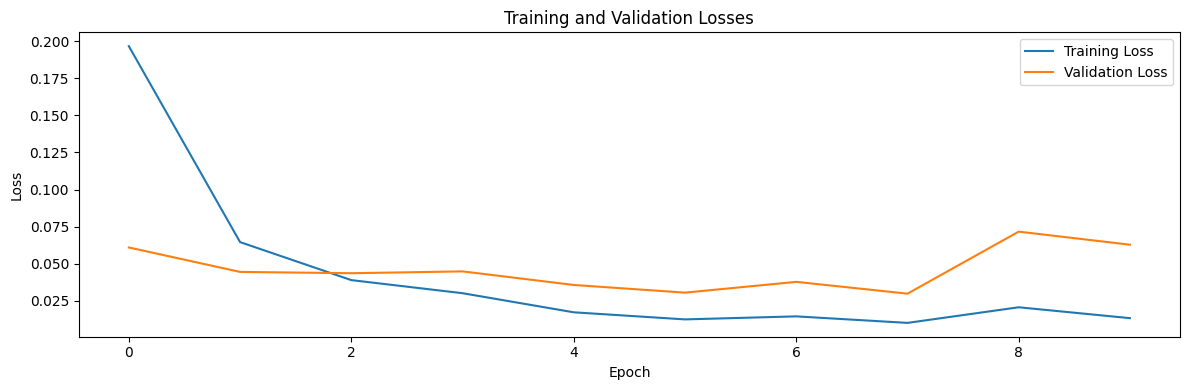

In [13]:
# Plotting losses
plt.figure(figsize=(12, 4))

plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Training and Validation Losses')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

## Train FC layer
 Now we exclusively train the ResNet50 model's final classification (fc) layer using Cross-Entropy Loss

In [17]:
# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(triplet_model.fc.parameters(), lr=0.001)  # Only train the fc layer

# Training and validation loop
train_losses=[]
train_acc=[]
val_losses=[]
val_acc=[]

for epoch in range(num_epochs):
  # Training phase
  triplet_model.train()
  train_loss = 0.0
  train_correct = 0
  val_correct= 0
  val_loss=0.0


  for inputs, labels in tqdm.tqdm(train_loader):

    inputs, labels = inputs.to(device), labels.to(device)

    optimizer.zero_grad()
    outputs = triplet_model(inputs)
    loss = criterion(outputs, labels)
    loss.backward()
    optimizer.step()

    train_loss += loss.item()
    pred=outputs.argmax(dim=1,keepdim=True)
    train_correct+=pred.eq(labels.view_as(pred)).sum().item()

  train_losses.append(train_loss/len(train_loader))
  train_acc.append(train_correct / len(train_loader.dataset))

  triplet_model.eval()
  with torch.no_grad():
    for inputs, labels in val_loader:
      inputs, labels = inputs.to(device), labels.to(device)
      outputs = triplet_model(inputs)
      loss = criterion(outputs, labels)
      val_loss += loss.item()
      pred=outputs.argmax(dim=1,keepdim=True)
      val_correct+=pred.eq(labels.view_as(pred)).sum().item()

  val_losses.append(val_loss / len(val_loader))
  val_acc.append(val_correct / len(val_loader.dataset))

  print(f"Epoch {epoch + 1}/{num_epochs}, Train Loss: {train_losses[-1]:.4f}, Train accuracy:{train_acc[-1]*100:.2f} Validation Loss: {val_losses[-1]:.4f}, Validation accuracy:{val_acc[-1]*100:.2f}")

100%|██████████| 125/125 [01:32<00:00,  1.36it/s]


Epoch 1/10, Train Loss: 0.2064, Train accuracy:97.55 Validation Loss: 0.1842, Validation accuracy:98.70


100%|██████████| 125/125 [01:32<00:00,  1.35it/s]


Epoch 2/10, Train Loss: 0.2084, Train accuracy:97.24 Validation Loss: 0.1770, Validation accuracy:98.55


100%|██████████| 125/125 [01:32<00:00,  1.36it/s]


Epoch 3/10, Train Loss: 0.2145, Train accuracy:96.96 Validation Loss: 0.1841, Validation accuracy:98.75


100%|██████████| 125/125 [01:31<00:00,  1.36it/s]


Epoch 4/10, Train Loss: 0.2107, Train accuracy:97.08 Validation Loss: 0.1727, Validation accuracy:98.50


100%|██████████| 125/125 [01:32<00:00,  1.35it/s]


Epoch 5/10, Train Loss: 0.2116, Train accuracy:97.14 Validation Loss: 0.1780, Validation accuracy:98.80


100%|██████████| 125/125 [01:32<00:00,  1.36it/s]


Epoch 6/10, Train Loss: 0.2147, Train accuracy:96.69 Validation Loss: 0.1741, Validation accuracy:98.55


100%|██████████| 125/125 [01:32<00:00,  1.36it/s]


Epoch 7/10, Train Loss: 0.2174, Train accuracy:97.08 Validation Loss: 0.1904, Validation accuracy:98.10


100%|██████████| 125/125 [01:32<00:00,  1.36it/s]


Epoch 8/10, Train Loss: 0.2112, Train accuracy:96.92 Validation Loss: 0.1786, Validation accuracy:98.60


100%|██████████| 125/125 [01:31<00:00,  1.36it/s]


Epoch 9/10, Train Loss: 0.2029, Train accuracy:97.59 Validation Loss: 0.1756, Validation accuracy:98.60


100%|██████████| 125/125 [01:32<00:00,  1.35it/s]


Epoch 10/10, Train Loss: 0.2109, Train accuracy:97.26 Validation Loss: 0.1731, Validation accuracy:98.75


## Plot Training and Validation Losses and Accuracies (with Triplet Loss)

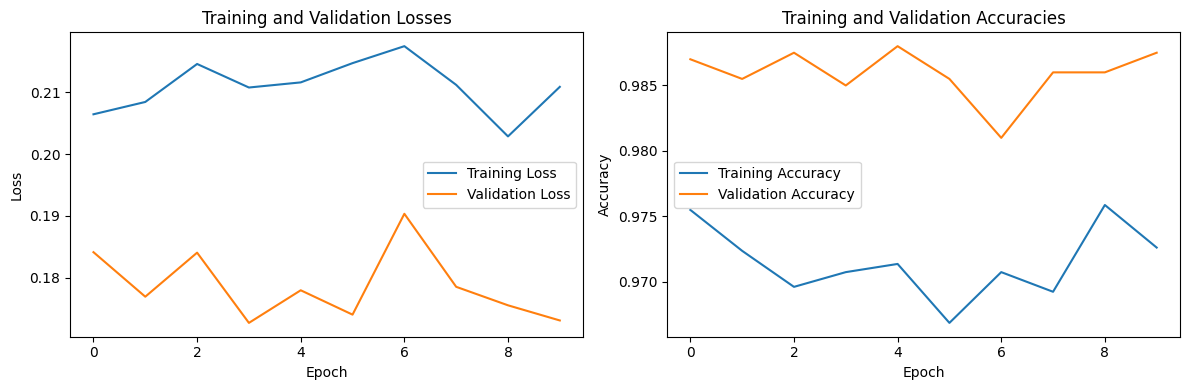

In [18]:
# Plotting losses
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Training and Validation Losses')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Plotting accuracies
plt.subplot(1, 2, 2)
plt.plot(train_acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.title('Training and Validation Accuracies')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()


## Test Accuracy

In [19]:
# Test
test_correct = 0
for inputs,labels in test_loader:
  inputs, labels = inputs.to(device), labels.to(device)
  outputs = triplet_model(inputs)
  pred=outputs.argmax(dim=1,keepdim=True)
  test_correct += pred.eq(labels.view_as(pred)).sum().item()

print(f"Test accuracy :{test_correct/len(test_loader.dataset)*100:.2f}")


Test accuracy :98.90


 The accuracy of using this approach is `98.90:`which is better than the last approach

# End to End model

In this section, we engage in end-to-end training of the model, incorporating both the triplet loss ($L_{triplet}$) and the cross-entropy loss $(L_{cross_entropy})$. The combined loss, denoted as $L_{total}$, is employed to optimize the model parameters comprehensively. This unified training approach aims to enhance both feature representation learning through triplet loss and overall classification accuracy through cross-entropy loss.


In [9]:
endtoend_model = timm.create_model('resnet50', pretrained=True)
endtoend_model.fc = nn.Linear(2048, 2)
endtoend_model = endtoend_model.to(device)


# Define both loss functions
criterion_triplet = nn.TripletMarginLoss()
criterion_cross_entropy = nn.CrossEntropyLoss()

# Define optimizer for all parameters
optimizer = optim.Adam(endtoend_model.parameters(), lr=0.001)

train_losses=[]
train_acc=[]
val_losses=[]
val_acc=[]

for epoch in range(num_epochs):
  # Training phase
  endtoend_model.train()
  train_loss = 0.0
  train_correct = 0
  val_correct= 0
  val_loss=0.0

  for anchors, positives, negatives, labels in tqdm.tqdm(triplet_train_loader):

    anchors, positives, negatives, labels = anchors.to(device), positives.to(device), negatives.to(device), labels.to(device)

    optimizer.zero_grad()
    anchor_outputs = endtoend_model(anchors)
    positive_outputs = endtoend_model(positives)
    negative_outputs = endtoend_model(negatives)
    loss_triplet = criterion_triplet(anchor_outputs, positive_outputs, negative_outputs)

    pred=anchor_outputs.argmax(dim=1,keepdim=True)
    #print(anchor_outputs)
    loss_cross_entropy = criterion_cross_entropy(anchor_outputs, labels)
    total_loss = loss_triplet + loss_cross_entropy
    total_loss.backward()
    optimizer.step()
    train_loss += total_loss.item()

    train_correct+=pred.eq(labels.view_as(pred)).sum().item()


  train_losses.append(train_loss/len(train_loader))
  train_acc.append(train_correct / len(train_loader.dataset))


  endtoend_model.eval()
  with torch.no_grad():
    for anchors, positives, negatives, labels in triplet_val_loader:
      anchors, positives, negatives, labels = anchors.to(device), positives.to(device), negatives.to(device), labels.to(device)
      anchor_outputs = endtoend_model(anchors)
      positive_outputs = endtoend_model(positives)
      negative_outputs = endtoend_model(negatives)
      loss_triplet = criterion_triplet(anchor_outputs, positive_outputs, negative_outputs)

      pred=anchor_outputs.argmax(dim=1,keepdim=True)
      loss_cross_entropy = criterion_cross_entropy(anchor_outputs, labels)

      total_loss = loss_triplet + loss_cross_entropy
      val_loss += total_loss.item()
      val_correct+=pred.eq(labels.view_as(pred)).sum().item()

  val_losses.append(val_loss / len(val_loader))
  val_acc.append(val_correct / len(val_loader.dataset))


  print(f"Epoch {epoch + 1}/{num_epochs}, Train Loss: {train_losses[-1]:.4f}, Train accuracy:{train_acc[-1]*100:.2f} Validation Loss: {val_losses[-1]:.4f}, Validation accuracy:{val_acc[-1]*100:.2f}")

100%|██████████| 250/250 [05:25<00:00,  1.30s/it]


Epoch 1/10, Train Loss: 0.6187, Train accuracy:95.35 Validation Loss: 0.0554, Validation accuracy:99.05


100%|██████████| 250/250 [05:25<00:00,  1.30s/it]


Epoch 2/10, Train Loss: 0.2144, Train accuracy:98.47 Validation Loss: 0.0559, Validation accuracy:98.00


100%|██████████| 250/250 [05:24<00:00,  1.30s/it]


Epoch 3/10, Train Loss: 0.1531, Train accuracy:98.92 Validation Loss: 0.0287, Validation accuracy:99.30


100%|██████████| 250/250 [05:22<00:00,  1.29s/it]


Epoch 4/10, Train Loss: 0.1453, Train accuracy:98.90 Validation Loss: 0.0336, Validation accuracy:99.20


100%|██████████| 250/250 [05:18<00:00,  1.27s/it]


Epoch 5/10, Train Loss: 0.0918, Train accuracy:99.41 Validation Loss: 0.0302, Validation accuracy:99.40


100%|██████████| 250/250 [05:17<00:00,  1.27s/it]


Epoch 6/10, Train Loss: 0.0964, Train accuracy:99.31 Validation Loss: 0.0292, Validation accuracy:99.25


100%|██████████| 250/250 [05:18<00:00,  1.27s/it]


Epoch 7/10, Train Loss: 0.0721, Train accuracy:99.48 Validation Loss: 0.0305, Validation accuracy:99.05


100%|██████████| 250/250 [05:18<00:00,  1.27s/it]


Epoch 8/10, Train Loss: 0.0614, Train accuracy:99.62 Validation Loss: 0.0333, Validation accuracy:99.00


100%|██████████| 250/250 [05:17<00:00,  1.27s/it]


Epoch 9/10, Train Loss: 0.0605, Train accuracy:99.64 Validation Loss: 0.0554, Validation accuracy:98.55


100%|██████████| 250/250 [05:18<00:00,  1.27s/it]


Epoch 10/10, Train Loss: 0.0715, Train accuracy:99.42 Validation Loss: 0.0343, Validation accuracy:99.25


## Plot Training and Validation Losses and Accuracies (End to End model)

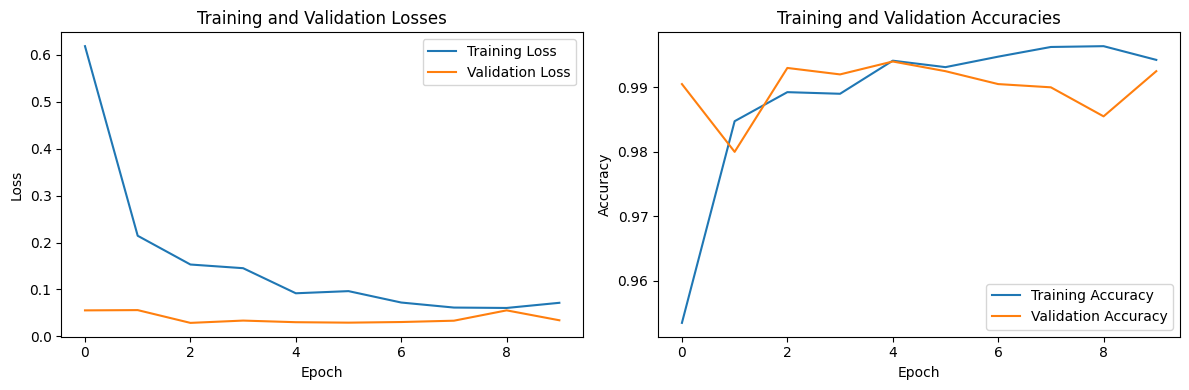

In [10]:
# Plotting losses
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Training and Validation Losses')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Plotting accuracies
plt.subplot(1, 2, 2)
plt.plot(train_acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.title('Training and Validation Accuracies')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()


## Test Accuracy

In [11]:
# Test
test_correct = 0
for inputs,labels in test_loader:
  inputs, labels = inputs.to(device), labels.to(device)
  outputs = endtoend_model(inputs)
  pred=outputs.argmax(dim=1,keepdim=True)
  test_correct += pred.eq(labels.view_as(pred)).sum().item()

print(f"Test accuracy :{test_correct/len(test_loader.dataset)*100:.2f}")


Test accuracy :99.30


 The accuracy of using training end-to-end model is `99.30`which is better than all previous approaches